# Making imports


In [206]:
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.optimize as opt
import torch
from tqdm import tqdm
from pyswarm import pso

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Task 4

## Generate random array

In [5]:
x = 3 * np.linspace(0, 1001, 1001) / 1000

y = 1 / (x**2 - 3*x + 2)

y[y < -100] = -100 + np.random.normal(0, 1, len(y[y < -100])) 
y[y > 100] = 100 + np.random.normal(0, 1, len(y[y > 100])) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


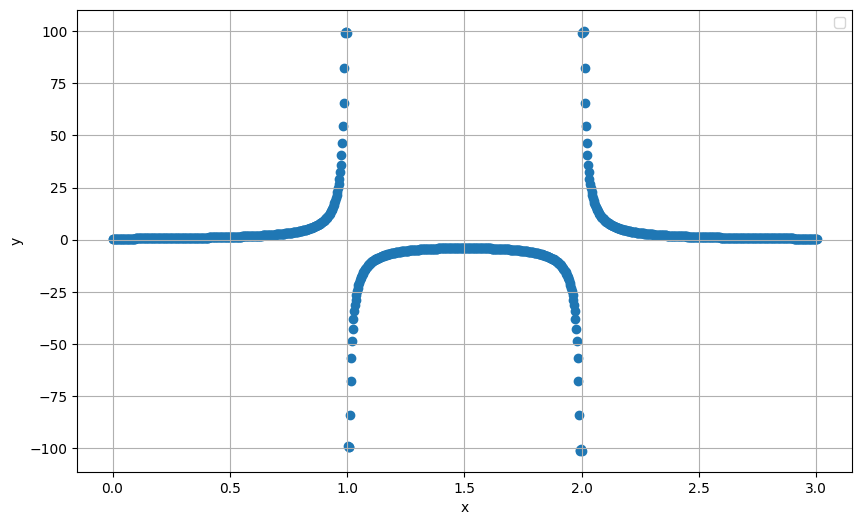

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y)
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.grid()
plt.show()

# Some more functions for graphs

In [65]:
colors = ['b','g','r','c','m','y','k']

def plot_aprox_result(x, y, methods_and_coafs, aprox_func, aprox_method_name, plot_full_only = False, figsize=(6,10), linewidth=3):
    
    if plot_full_only:
       num_of_plots = 1
    else:
        num_of_plots = len(methods_and_coafs) + 1

    fig, ax = plt.subplots(num_of_plots, figsize=(10, num_of_plots * 5))
    
    fig.suptitle(aprox_method_name)
    
    if not plot_full_only:
        for idx, (method) in enumerate(methods_and_coafs) :
            ax[idx].scatter(x, y)
            coef = methods_and_coafs[method]
            
            color = colors[idx]
            ax[idx].plot(x, aprox_func(x, *coef), linewidth=linewidth, label=method, color=color)
            ax[idx].set(xlabel='x', ylabel='y')
        
            ax[idx].legend()
            ax[idx].grid()
        
        num_of_plots -= 1
        ax[num_of_plots].scatter(x, y)
        ax[num_of_plots].set(xlabel='x', ylabel='y')

        for idx, (method) in enumerate(methods_and_coafs):
        
            coef = methods_and_coafs[method]
            print(coef)

            color = colors[idx]
            ax[num_of_plots].plot(x, aprox_func(x, *coef), linewidth=linewidth, label=method, color=color)

            ax[num_of_plots].legend()
            ax[num_of_plots].grid()
    else:
        ax.scatter(x, y)
        ax.set(xlabel='x', ylabel='y')
        
        for idx, (method) in enumerate(methods_and_coafs):
        
            coef = methods_and_coafs[method]
            print(coef)
            
            color = colors[idx]
            ax.plot(x, aprox_func(x, *coef ), linewidth=linewidth, label=method, color=color)
        
            ax.legend()
            ax.grid()
        
    plt.show()

In [8]:
def make_table_2d(table_data,
               row_headers = ['exhaustive_search_2d','Gauss','Nelder-Mead'],
               column_headers = ['iter_count','f_calc_count', 'squared error']):
    
    for data in table_data:
        data[2] = round(data[2], 2)
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table_data,
        rowLabels=row_headers,
        colLabels=column_headers,
        loc='center',
        cellLoc='center')

    plt.show()

# Defining loss functions for regression

In [28]:
def rational(x, a, b, c, d):
    return (a * x + b) / (x**2 + c * x + d)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params): 
    x, y = params
    a, b, c, d  = z
    return np.sum((rational(x, a, b, c, d) - y)**2)

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params): 
    x, y = params
    a, b, c, d = z
    return rational(x, a, b, c, d) - y

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b, c, d): 
    return np.sum((rational(x, a, b, c, d) - y)**2)

# Calculating regression coefs by different methods

# Nelder-Mead

In [43]:
eps = 0.001

In [14]:
initial_guess = [0.1, 0.1, 0.1, 0.1]
nelder_mead = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = eps)

In [29]:
nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

# Levenberg-Marquardt rational

In [44]:
initial_guess = [-0.1, -0.1, 0.1, 0.1]
lma = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), ftol=eps, xtol=eps, method='lm')

In [45]:
lma_result = [len(lma['fun']), lma['nfev'], lma['cost']]

# Differential evolution

In [199]:
bounds = np.array([[-10, 10],[-10, 10],[-10, 10],[-10, 10]])
diff_evo = opt.differential_evolution(loss_rational, bounds, args=(x, y), tol=eps)

In [200]:
diff_evo

 message: Optimization terminated successfully.
 success: True
     fun: 195790.57020516615
       x: [-4.169e+00  1.785e+00  7.485e+00 -8.499e+00]
     nit: 119
    nfev: 7290
     jac: [-1.979e-01  1.659e-01  5.504e+00  7.023e+00]

In [62]:
diff_evo_result = [diff_evo['nit'], diff_evo['nfev'], diff_evo['fun']]

# Annieling

In [188]:
from numpy import exp
from numpy.random import randn
from numpy.random import rand

def simulated_annealing(loss, initial_guess, x, y, n_iterations, step_size, max_temp):
	dims = len(initial_guess)
	best = initial_guess

	best_eval = loss(x, y, *best)
	curr, curr_eval = best, best_eval

	temperature_sched = list(max_temp / np.linspace(1, n_iterations, n_iterations))
	
	for t in temperature_sched:
		candidate = curr + randn(dims) * step_size
	
		candidate_eval = loss(x, y, *candidate)

		if candidate_eval < best_eval:
			best, best_eval = candidate, candidate_eval

		diff = candidate_eval - curr_eval
		
		# calculate metropolis acceptance criterion
		metropolis = exp(-diff / t)
		# check if we should keep the new point
		if diff < 0 or rand() < metropolis:
			# store the new current point
			curr, curr_eval = candidate, candidate_eval
	return best, best_eval

In [189]:
initial_guess = [-3, 3, -3, 3]
n_iterations = 1000
annealing, score = simulated_annealing(f_loss_rational, initial_guess, x, y, n_iterations=n_iterations, step_size=0.1, max_temp=10000)
annealing, score 

(array([-2.13591391,  2.17687841, -1.98084788,  0.98404443]),
 237120.23852134563)

In [184]:
annealing_result = [n_iterations, n_iterations, score]

# Swarm

In [212]:
lower_bound = np.array([-10]*4)
upper_bound = np.array([10]*4)
swam, fopt = pso(loss_rational, lower_bound, upper_bound, maxiter=1000, args=(x, y), swarmsize=1000, minfunc=0.0001)
swam = list(swam)

Stopping search: maximum iterations reached --> 1000


# Combined grahps

[ 0.87738459 -1.75603461 -4.0025818   4.00517748]
[-0.09920828 -0.05918013  0.1060809   0.12935835]
[-4.16890136  1.78540798  7.48504772 -8.49924166]
[-2.13591391  2.17687841 -1.98084788  0.98404443]
[1.3418151060140546, -2.684526837411044, -3.999012399629074, 3.9980642049074757]


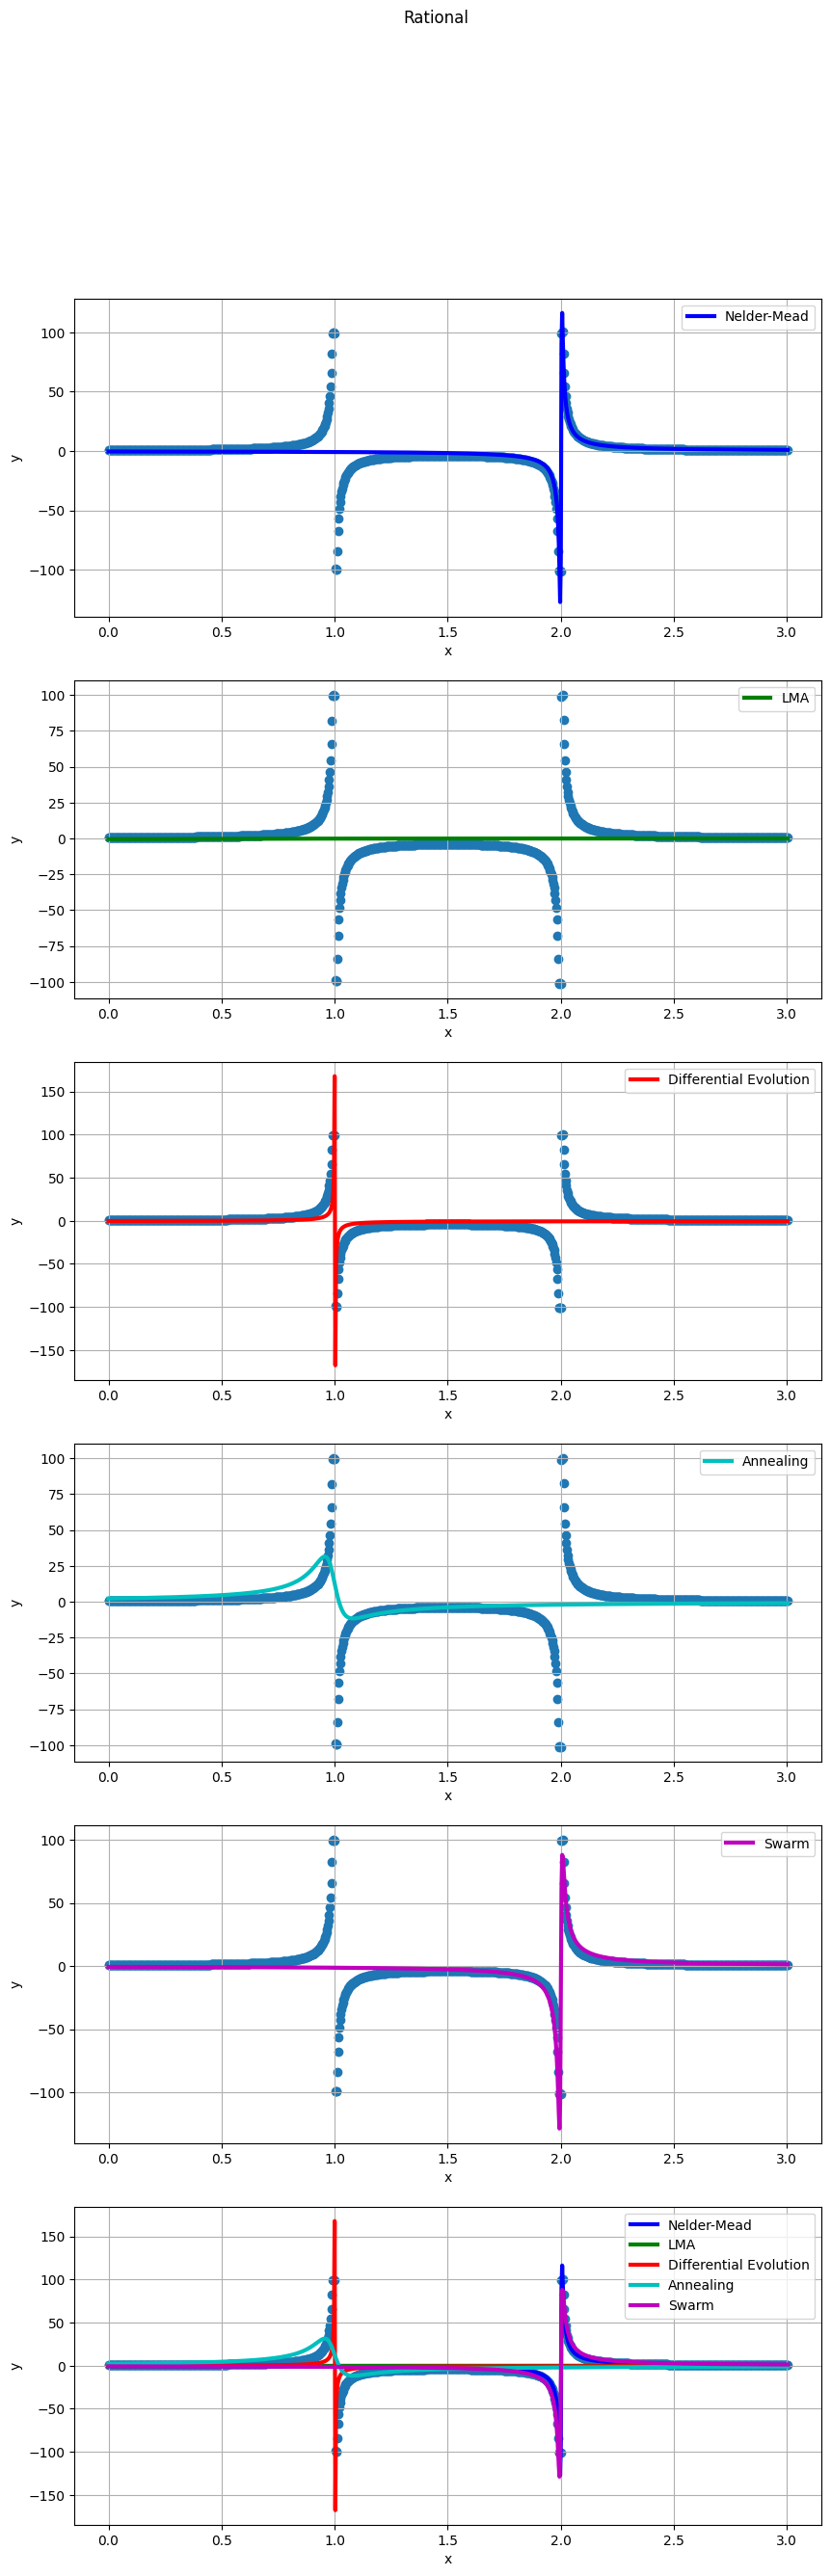

In [213]:
methods_and_coafs_full = {
    'Nelder-Mead': nelder_mead['x'],
    'LMA': lma['x'],
    'Differential Evolution': diff_evo['x'],
    'Annealing': annealing,
    'Swarm':swam
}

plot_aprox_result(x, y, methods_and_coafs_full, rational, 'Rational',figsize=(10,20))

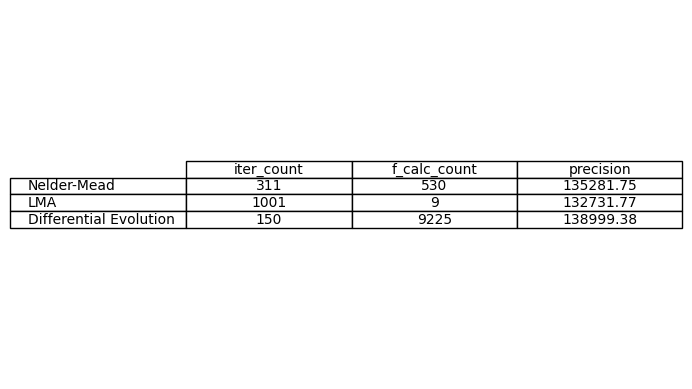

In [67]:
make_table_2d([nelder_mead_result,
               lma_result,
               diff_evo_result],
               row_headers = list(methods_and_coafs_full.keys()),
               column_headers = ['iter_count','f_calc_count', 'precision'])